In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sejongai-hashrate/train.csv
/kaggle/input/sejongai-hashrate/test.csv
/kaggle/input/sejongai-hashrate/submit_sample.csv


* ## 데이터 로드

In [2]:
train = pd.read_csv('/kaggle/input/sejongai-hashrate/train.csv')
test = pd.read_csv('/kaggle/input/sejongai-hashrate/test.csv')
sample = pd.read_csv('/kaggle/input/sejongai-hashrate/submit_sample.csv')

## 모듈 임포트 및 GPU 사용

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import StandardScaler

device ='cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda' :
  torch.cuda.manual_seed_all(777)

device

'cuda'

* train data

In [4]:
train

,id,Timestamp,n-payments-per-block,miners-revenue,trade-volume,avg-block-size,n-unique-addresses,difficulty,hash-rate
0,328,9/25/2019 0:00,3714,0.166294,0.147157,1.104534,0.407111,1190,90.858160
1,523,4/7/2020 0:00,3302,0.146596,0.060107,1.137403,0.364428,1390,104.430894
2,1086,10/22/2021 0:00,4256,0.775290,0.281810,1.168189,0.613513,2010,146.706532
3,215,6/4/2019 0:00,4677,0.163721,0.051685,1.253258,0.587934,746,51.200279
4,256,7/15/2019 0:00,4278,0.198286,0.043616,1.136104,0.429397,906,64.994549
...,...,...,...,...,...,...,...,...,...
864,330,9/27/2019 0:00,3955,0.120062,0.082400,1.095424,0.345911,1280,91.434682
865,466,2/10/2020 0:00,3818,0.145750,0.025907,1.199867,0.515415,1550,110.381153
866,121,3/2/2019 0:00,3905,0.025145,0.041302,1.155579,0.266085,607,44.696377
867,1044,9/10/2021 0:00,4515,0.464794,0.091534,1.194476,0.465419,1840,135.548079


* ## 데이터 파싱

In [5]:
x_train = train.iloc[:,1:-1]
x_train['Timestamp'] = x_train['Timestamp'].str.split(' ').str[0]
x_train['date'] = x_train['Timestamp'].str.split('/').str[0].astype(int)
x_train['month'] = x_train['Timestamp'].str.split('/').str[1].astype(int)
x_train['year'] = x_train['Timestamp'].str.split('/').str[2].astype(int)
x_train = x_train.drop(['Timestamp'], axis=1)

x_test = test.iloc[:,1:]
x_test['Timestamp'] = x_test['Timestamp'].str.split(' ').str[0]
x_test['date'] = x_test['Timestamp'].str.split('/').str[0].astype(int)
x_test['month'] = x_test['Timestamp'].str.split('/').str[1].astype(int)
x_test['year'] = x_test['Timestamp'].str.split('/').str[2].astype(int)
x_test = x_test.drop([ 'Timestamp'], axis=1)

y_train = train.iloc[:,-1]


sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train = torch.FloatTensor(x_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_train = torch.FloatTensor(y_train).reshape(-1,1).to(device)

* ## 데이터 확인

In [6]:
# train data
print(x_train[:5])
print(x_train.shape)
print(y_train[:5])
print(y_train.shape)

# test data
print(x_test[:3])

tensor([[-0.4009, -0.2973,  0.5300, -0.3541, -0.2453, -0.4522,  0.7352,  1.0807,
         -0.9310],
        [-0.9151, -0.3917, -0.3157, -0.1477, -0.4899, -0.0833, -0.7241, -0.9701,
          0.1895],
        [ 0.2755,  2.6196,  1.8380,  0.0455,  0.9379,  1.0601,  1.0271,  0.7389,
          1.3101],
        [ 0.8010, -0.3096, -0.3975,  0.5795,  0.7913, -1.2710, -0.1404, -1.3119,
         -0.9310],
        [ 0.3030, -0.1441, -0.4759, -0.1559, -0.1175, -0.9759,  0.1515, -0.0586,
         -0.9310]], device='cuda:0')
torch.Size([869, 9])
tensor([[ 90.8582],
        [104.4309],
        [146.7065],
        [ 51.2003],
        [ 64.9946]], device='cuda:0')
torch.Size([869, 1])
tensor([[-0.1937, -0.2663, -0.6790,  0.3013,  1.0558,  0.4884,  1.3190,  0.0553,
          0.1895],
        [-1.7837, -0.8732,  0.0416, -1.7283, -1.4705, -1.7044,  1.6108,  1.3086,
         -2.0515],
        [ 0.4128, -0.6712, -0.5372,  0.0717,  0.7904,  0.5437,  0.7352, -0.0586,
          0.1895]], device='cuda:0')


* ## 모델 정의

In [7]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        
        self.linear1 = nn.Linear(9,512,bias=True)
        self.linear2 = nn.Linear(512,256,bias=True)
        self.linear3 = nn.Linear(256,512,bias=True)
        self.linear4 = nn.Linear(512,64,bias=True)
        self.linear5 = nn.Linear(64,32,bias=True)
        self.linear6 = nn.Linear(32,1,bias=True)
        self.relu = nn.ReLU()
        
        torch.nn.init.orthogonal_(self.linear1.weight)
        torch.nn.init.orthogonal_(self.linear2.weight)
        torch.nn.init.orthogonal_(self.linear3.weight)
        torch.nn.init.orthogonal_(self.linear4.weight)
        torch.nn.init.orthogonal_(self.linear5.weight)
        torch.nn.init.orthogonal_(self.linear6.weight)
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.linear6(out)
        return out

* ## 학습 파라미터 설정

In [8]:
model = NN().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
loss = nn.MSELoss().to(device)
epochs = 2000
model

NN(
  (linear1): Linear(in_features=9, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

* # 모델 학습

In [9]:
model.train()
plt_los = []
train_total_batch = len(x_train)
for epoch in range(epochs+1) : 
    avg_cost = 0
    model.train()

    hypothesis = model(x_train) 
    cost = loss(hypothesis,y_train) 
    
    optimizer.zero_grad() 
    cost.backward()
    optimizer.step() 
    avg_cost += cost / train_total_batch
    plt_los.append([avg_cost.item()])
    if epoch%200==0:
        print('Epoch : {}, Cost : {}'.format(epoch, avg_cost.item()))


Epoch : 0, Cost : 13.872109413146973
Epoch : 200, Cost : 0.15140527486801147
Epoch : 400, Cost : 0.05734240636229515
Epoch : 600, Cost : 0.034110601991415024
Epoch : 800, Cost : 0.025000613182783127
Epoch : 1000, Cost : 0.01837957091629505
Epoch : 1200, Cost : 0.01364353857934475
Epoch : 1400, Cost : 0.010211610235273838
Epoch : 1600, Cost : 0.007697619963437319
Epoch : 1800, Cost : 0.0056938230991363525
Epoch : 2000, Cost : 0.004402837250381708


## cost 확인

In [10]:
import matplotlib.pyplot as plt

def plot(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]

    plt.figure(figsize=(10, 10))
    plt.plot(bn, label='avg_cost')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

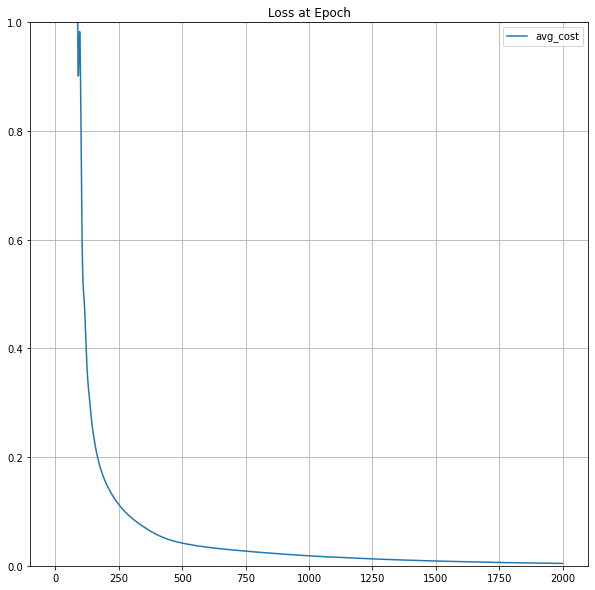

0.004402837250381708


In [11]:
plot(plt_los , [0.0, 1.0], title='Loss at Epoch')
print(avg_cost.item())

## 예측 값 도출 및 제출

In [12]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

In [13]:
sample['hash-rate'] = y_pred.cpu().numpy()
sample.to_csv('submit_sample.csv',index=False)

In [14]:
sample

,id,hash-rate
0,746,131.405334
1,56,40.596966
2,684,135.314224
3,896,175.725327
4,723,139.804413
...,...,...
213,1043,138.360199
214,661,125.209763
215,894,160.315567
216,828,152.756439
